In [1]:
import xarray as xr
import os
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime
import glob
from functools import reduce
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from datetime import datetime as dt

In [2]:
site='NSF_sites/ERA5/TKL873'
station_lat = 67.60998953
station_lon = -162.5877864

datestring = ''
var_names = {
    'temp': ['download_daily_mean_2m_temperature*', 't2m'], #air temperature, Kelvin
    'dewpoint_temp': ['download_daily_mean_2m_dewpoint_temperature*', 'd2m'], #dewpoint temperature, Kelvin
    'wind_u': ['download_daily_mean_10m_u_component_of_wind*', 'u10'], #wind speed u , m s-1
    'wind_v': ['download_daily_mean_10m_v_component_of_wind*', 'v10'], #wind speed u , m s-1
    'pressure': ['download_daily_mean_surface_pressure*', 'sp'], #air pressure, Pa
    'shortwave': ['download_daily_mean_surface_solar_radiation_downwards*', 'ssrd'], #shortwave radiation, J m-2
    'longwave': ['download_daily_mean_surface_thermal_radiation_downwards*', 'strd'], #longwave radiation, J m-2
    #'total_precip': ['download_daily_mean_total_precipitation*', 'tp'], #total precip, mean of hourly, m
    'precip_rate': ['download_daily_mean_mean_total_precipitation_rate*', 'mtpr'] #precip rate, kg m-2 s-1
}

dates = list(set([d[-10:-3] for d in os.listdir('NSF_sites/ERA5/TKL873')]))

In [3]:
date_dfs = []

for var_name in var_names:
    
    var_files = glob.glob(os.path.join(site, var_names[var_name][0]))
    var_dfs = []
    
    for var_file in var_files:

        ds = xr.open_dataset(var_file)
        ds = ds.sel(lon=station_lon, lat=station_lat, method="nearest")
        ds_varname = list(ds.data_vars.keys())[0]
        ds_df = pd.DataFrame({'time': ds['time'], var_name: ds[ds_varname]})  
        var_dfs.append(ds_df)

    if var_dfs==[]:
        continue
        
    var_df = pd.concat(var_dfs)

    date_dfs.append(var_df)

data_df = reduce(lambda  left,right: pd.merge(left,right,on=['time'],
                                            how='outer'), date_dfs).sort_values(by='time')

In [4]:
data_df['shortwave'] = data_df['shortwave']/3600 #J m-2 (daily average of cumulative hourly rad) -> daily average rad in w m-2
data_df['longwave'] = data_df['longwave']/3600 #J m-2 (daily average of cumulative hourly rad) -> daily average rad in w m-2
data_df['precip_rate'] = data_df['precip_rate'] / 1000 #kg m-2 s-2 to m s-1

##### calculate humidity ##########


In [5]:
def calc_vp(temp_K):
    
    a = 2.5008e6/461.2
    b = (1/273.16) - (1/temp_K)
    
    return 611.12*np.exp(a*b) #vapor pressure in Pa
    
def calc_vp_v2(temp_K):
    
    temp_C = temp_K - 273.15
    
    return 6.11*np.power(10,(7.5*temp_C)/(237.3+temp_C)) * 100 #vapor pressure in Pa
    
def calc_mr(pres, vapor_pres):
    #pressures in Pa
    return (vapor_pres * 0.622) / (pres - vapor_pres) #kg water / kg dry air

def calc_rh(temp, dewpoint_temp):
    
    return (calc_vp(dewpoint_temp) / calc_vp(temp)) * 100 #rh, in %

In [6]:
vp =  calc_vp(data_df['dewpoint_temp'])
data_df['mixing_ratio'] = calc_mr(data_df['pressure'], vp)
data_df['relative_humidity'] = calc_rh(data_df['temp'], data_df['dewpoint_temp'])

In [7]:
path_to_insitu = '/home/amullen/Lake-Model-Data/data/NSF_sites/in_situ/RH_Tair_summary_summer_2023.xlsx'
df_obs = pd.read_excel(path_to_insitu, sheet_name='TKL_873', skiprows=1, parse_dates=['Date Time, GMT-06:00'])
df_obs = df_obs[['Date Time, GMT-06:00', 'Temp, °C (LGR S/N: 20903701, SEN S/N: 20901876)', 'RH, % (LGR S/N: 20903701, SEN S/N: 20901876)']]
df_obs = df_obs.rename(columns={'Date Time, GMT-06:00': 'time','Temp, °C (LGR S/N: 20903701, SEN S/N: 20901876)': 'temp_C_obs', 'RH, % (LGR S/N: 20903701, SEN S/N: 20901876)': 'RH_pct_obs'})
df_obs['day'] = pd.to_datetime(df_obs['time'].dt.date)
df_obs['temp_K_obs'] = df_obs['temp_C_obs']+273.15
df_obs=df_obs.dropna()
df_obs_daily = df_obs.groupby(by='day').mean().reset_index()
df_obs_daily = pd.merge(df_obs_daily, data_df[['time', 'temp', 'relative_humidity']], how='inner', left_on='day', right_on='time')

mae_temp = mean_absolute_error(df_obs_daily['temp_K_obs'], df_obs_daily['temp'])
rmse_temp = mean_squared_error(df_obs_daily['temp_K_obs'], df_obs_daily['temp'])
r2_temp = r2_score(df_obs_daily['temp_K_obs'], df_obs_daily['temp'])
bias_temp = df_obs_daily['temp'].mean() - df_obs_daily['temp_K_obs'].mean()

mae_rh = mean_absolute_error(df_obs_daily['RH_pct_obs'], df_obs_daily['relative_humidity'])
rmse_rh = mean_squared_error(df_obs_daily['RH_pct_obs'], df_obs_daily['relative_humidity'])
r2_rh = r2_score(df_obs_daily['RH_pct_obs'], df_obs_daily['relative_humidity'])
bias_rh = df_obs_daily['relative_humidity'].mean() - df_obs_daily['RH_pct_obs'].mean()

/tmp/ipykernel_240051/1510429392.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_obs_daily = df_obs.groupby(by='day').mean().reset_index()


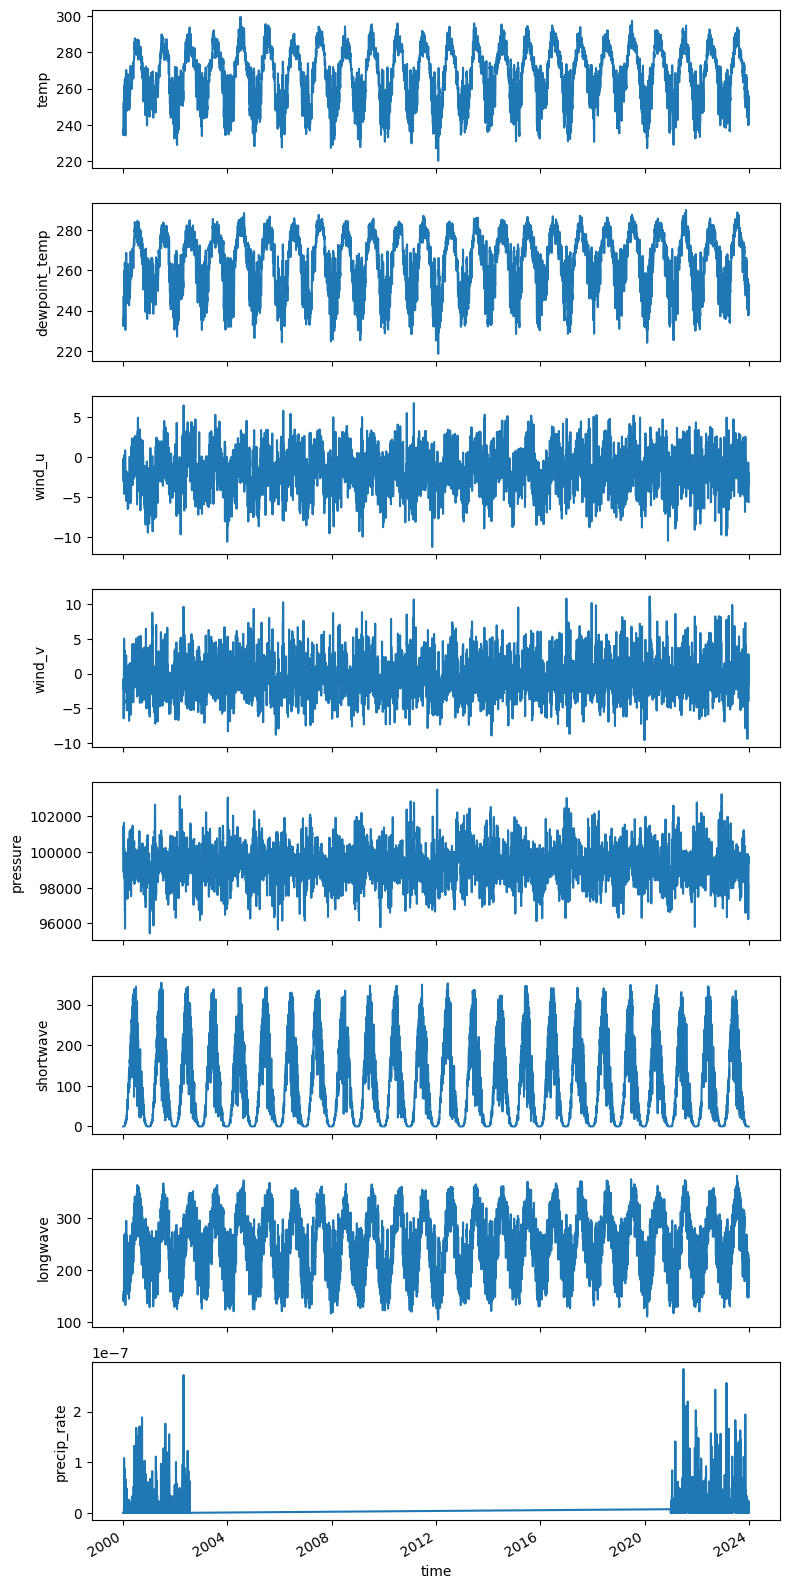

In [8]:
fig, axes = plt.subplots(len(var_names),1, figsize=(8, 2*len(var_names)), sharex=True)

for i, var in enumerate(var_names):
    sns.lineplot(x=data_df['time'], y=data_df[var], ax=axes[i])
fig.autofmt_xdate()
fig.tight_layout()

plt.savefig('NSF_sites/figs/TKL873_data.jpg', dpi=300)

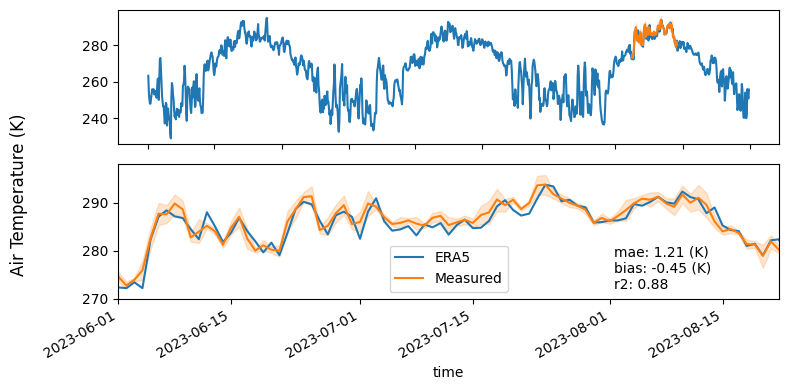

In [9]:
fig, axes = plt.subplots(2,1,figsize=(8,4))

sns.lineplot(x=data_df['time'], y=data_df['temp'], ax=axes[0])
sns.lineplot(x=df_obs['day'], y=df_obs['temp_K_obs'], ax=axes[0])
axes[0].set_ylabel('')


sns.lineplot(x=data_df['time'], y=data_df['temp'], ax=axes[1], label='ERA5')
sns.lineplot(x=df_obs['day'], y=df_obs['temp_K_obs'], ax=axes[1], label='Measured')
axes[1].set_ylabel('')

axes[1].set_xlim(df_obs['day'].min(), df_obs['day'].max())
axes[1].set_ylim(270, 298)

axes[1].text(0.75, 0.07, 
             f'mae: {"%.2f" % mae_temp} (K)\n'
             f'bias: {"%.2f" % bias_temp} (K)\n'
             f'r2: {"%.2f" % r2_temp}',
             transform=axes[1].transAxes,
             horizontalalignment='left')

fig.supylabel('Air Temperature (K)')
fig.autofmt_xdate()
fig.tight_layout()

plt.savefig('NSF_sites/figs/TKL873_tair_comp.jpg', dpi=300)

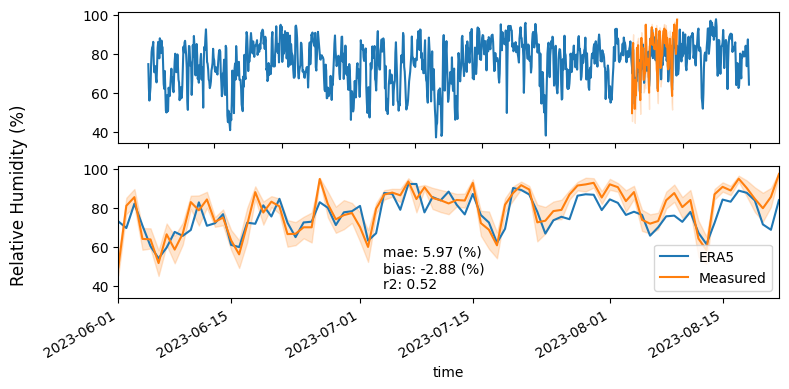

In [10]:
fig, axes = plt.subplots(2,1,figsize=(8,4))

sns.lineplot(x=data_df['time'], y=data_df['relative_humidity'], ax=axes[0])
sns.lineplot(x=df_obs['day'], y=df_obs['RH_pct_obs'], ax=axes[0])
axes[0].set_ylabel('')


sns.lineplot(x=data_df['time'], y=data_df['relative_humidity'], ax=axes[1], label='ERA5')
sns.lineplot(x=df_obs['day'], y=df_obs['RH_pct_obs'], ax=axes[1], label='Measured')
axes[1].set_ylabel('')

axes[1].set_xlim(df_obs['day'].min(), df_obs['day'].max())

axes[1].text(0.4, 0.07, 
             f'mae: {"%.2f" % mae_rh} (%)\n'
             f'bias: {"%.2f" % bias_rh} (%)\n'
             f'r2: {"%.2f" % r2_rh}',
             transform=axes[1].transAxes,
             horizontalalignment='left')

fig.supylabel('Relative Humidity (%)')
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('NSF_sites/figs/TKL873_rh_comp.jpg', dpi=300)

# Format for LAKE
### LAKE Parameters for reference

* N_header_lines* --- the number of lines, occupied by file header 
* N_coloumns*     --- the total number of coloumns in the file
* N_Year*         --- the number of coloumn with the number of year (not used in the model)
* N_Month*        --- the number of coloumn with the number of month (not used in the model)
* N_Day*          --- the number of coloumn with the number of day (not used in the model)
* N_Hour*         --- the number of coloumn with the number of hour (not used in the model)
* N_Uspeed*       --- the number of coloumn with x-component speed values,      (m/s)
* N_Vspeed*       --- the number of coloumn with y-component speed values,      (m/s)
* N_Temp*         --- the number of coloumn with air temperature values,        (K)
* N_Hum*          --- the number of coloumn with air humidity values,           (kg/kg)
* N_Pres*         --- the number of coloumn with atmospheric pressure value,s   (Pa)
* N_SWdown*       --- the number of coloumn with net solar radiation values,    (W/m**2)
* N_LWdown*       --- the number of coloumn with net longwave radiation values, (W/m**2)
* N_Precip*       --- the number of coloumn with precipitation intensity,       (m/s)

In [11]:
data_df['year'] = data_df['time'].dt.year
data_df['month'] = data_df['time'].dt.month
data_df['day'] = data_df['time'].dt.day
data_df.columns

Index(['time', 'temp', 'dewpoint_temp', 'wind_u', 'wind_v', 'pressure',
       'shortwave', 'longwave', 'precip_rate', 'mixing_ratio',
       'relative_humidity', 'year', 'month', 'day'],
      dtype='object')

In [12]:
data_df_LAKE= data_df[['year', 'month', 'day', 'wind_u', 'wind_v',
                        'temp', 'mixing_ratio', 'pressure', 'shortwave', 'longwave', 'precip_rate']]
data_df_LAKE.columns=['Year','Month','Day','Uspeed','Vspeed','Temp','Hum','Pres','SWdown','LWdown','Precip']

In [13]:
data_df_LAKE.to_csv('NSF_sites/LAKE/TKL873.dat', index=False)

In [14]:
data_df_avg = data_df_LAKE.groupby(by=['Month', 'Day']).mean().reset_index()

In [15]:
data_df_avg['Precip'] = data_df_LAKE['Precip'].mean()

In [16]:
spin_years = 20

data_df_avg = pd.concat([data_df_avg]*spin_years, ignore_index=True)
data_df_avg['Year'] = [2023-spin_years+i for i in range(0,spin_years) for n in range(0,365)]


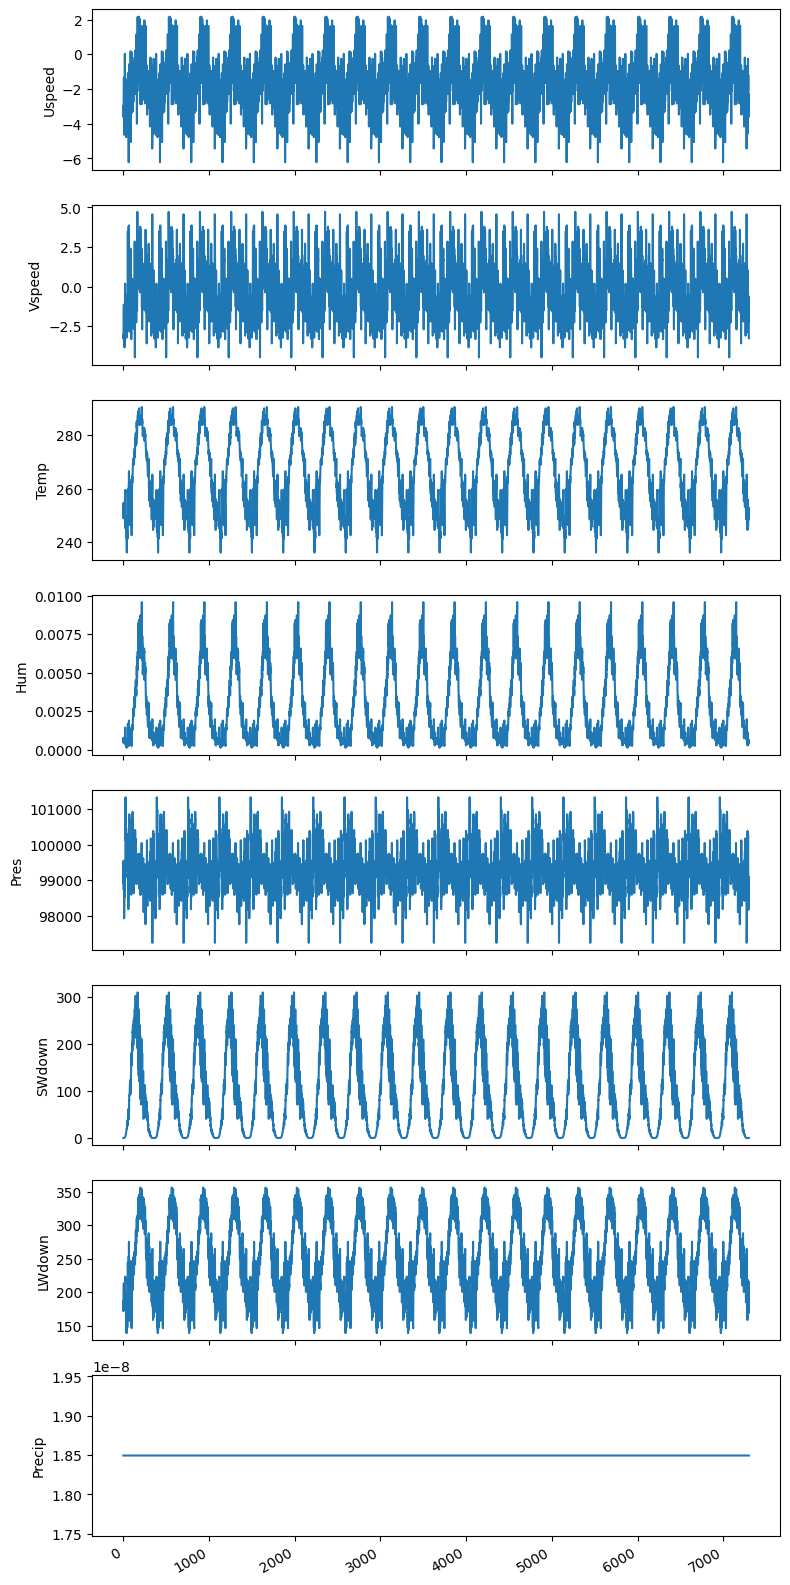

In [17]:
var_names = ['Uspeed','Vspeed','Temp','Hum','Pres','SWdown','LWdown','Precip']
fig, axes = plt.subplots(len(var_names),1, figsize=(8, 2*len(var_names)), sharex=True)

for i, var in enumerate(var_names):
    sns.lineplot(x=data_df_avg.index, y=data_df_avg[var], ax=axes[i])
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('NSF_sites/figs/TKL873_spinup.jpg', dpi=300)

In [18]:
data_df_avg = data_df_avg.reindex(columns=['Year','Month','Day','Uspeed','Vspeed','Temp','Hum','Pres','SWdown','LWdown','Precip'])
data_df_avg.to_csv('NSF_sites/LAKE/TKL873-spinup.dat', index=False)

In [19]:
data_df_avg

,Year,Month,Day,Uspeed,Vspeed,Temp,Hum,Pres,SWdown,LWdown,Precip
0,2003,1,1,-2.987668,-3.082369,254.423950,0.000771,98932.156250,0.000000,186.162216,1.849513e-08
1,2003,1,2,-3.374490,-3.290057,249.471313,0.000469,99021.898438,0.000000,171.542068,1.849513e-08
2,2003,1,3,-3.614390,-2.605657,248.889526,0.000503,99347.992188,0.000000,173.580124,1.849513e-08
3,2003,1,4,-3.117215,-1.940783,249.942459,0.000556,99546.843750,0.001481,177.062195,1.849513e-08
4,2003,1,5,-2.590897,-1.817662,251.069763,0.000476,99157.312500,0.006420,193.215271,1.849513e-08
...,...,...,...,...,...,...,...,...,...,...,...
7295,2022,12,27,-2.668862,-2.157633,248.332458,0.000389,98451.125000,0.000000,174.090805,1.849513e-08
7296,2022,12,28,-3.291921,-0.610831,252.097046,0.000570,98690.343750,0.000000,208.439636,1.849513e-08
7297,2022,12,29,-3.599674,-1.914774,252.686783,0.000647,98458.132812,0.000000,215.770493,1.849513e-08
7298,2022,12,30,-2.254862,-2.474055,250.000443,0.000483,99070.398438,0.000000,185.156784,1.849513e-08
